In [46]:
from google.colab import files
uploaded = files.upload()

Saving Electric_Production.csv to Electric_Production.csv


In [47]:
import pandas as pd

In [48]:
ts = pd.read_csv('Electric_Production.csv')

In [51]:
ts.head()

,DATE,IPG2211A2N
0,1985-01-01,72.5052
1,1985-02-01,70.6720
2,1985-03-01,62.4502
3,1985-04-01,57.4714
4,1985-05-01,55.3151


In [50]:
ts['DATE'] = pd.to_datetime(ts['DATE'])

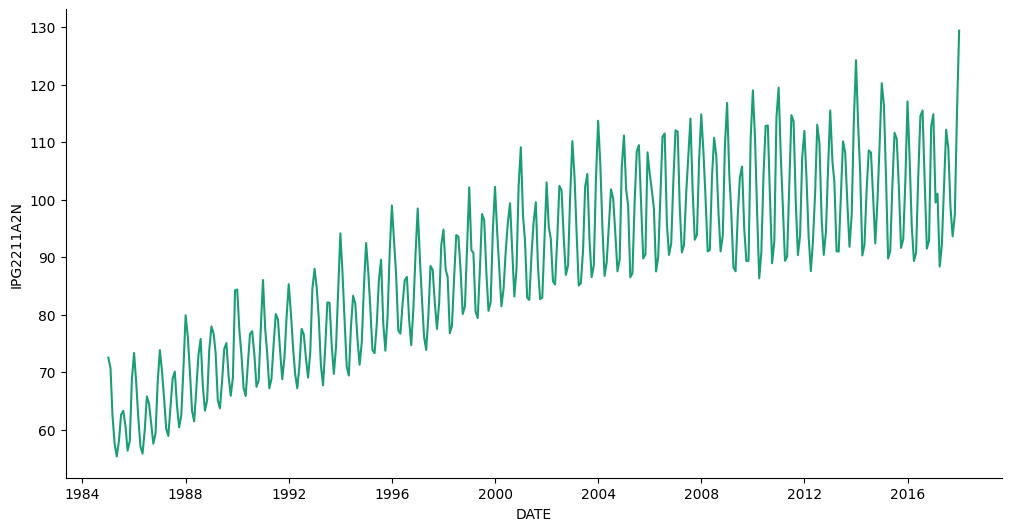

In [52]:
from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['DATE']
  ys = series['IPG2211A2N']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
ts_sorted = ts.sort_values('DATE', ascending=True)
_plot_series(ts_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('DATE')
_ = plt.ylabel('IPG2211A2N')

In [53]:
ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   DATE        397 non-null    datetime64[ns]
 1   IPG2211A2N  397 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 6.3 KB


In [54]:
# Проверяем ряд на стационарность по Дики-Фуллеру
from statsmodels.tsa.stattools import adfuller

result = adfuller(ts['IPG2211A2N'])

# результат — это tuple:
print('ADF Statistic:', result[0])       # статистика теста
print('p-value:', result[1])             # p-значение
print('Used lags:', result[2])           # число лагов
print('Number of observations:', result[3])  # число наблюдений
print('Critical Values:', result[4])     # критические значения

ADF Statistic: -2.256990350047235
p-value: 0.1862146911658712
Used lags: 15
Number of observations: 381
Critical Values: {'1%': np.float64(-3.4476305904172904), '5%': np.float64(-2.869155980820355), '10%': np.float64(-2.570827146203181)}


Так как p > 0.05, то ряд нестационарен.

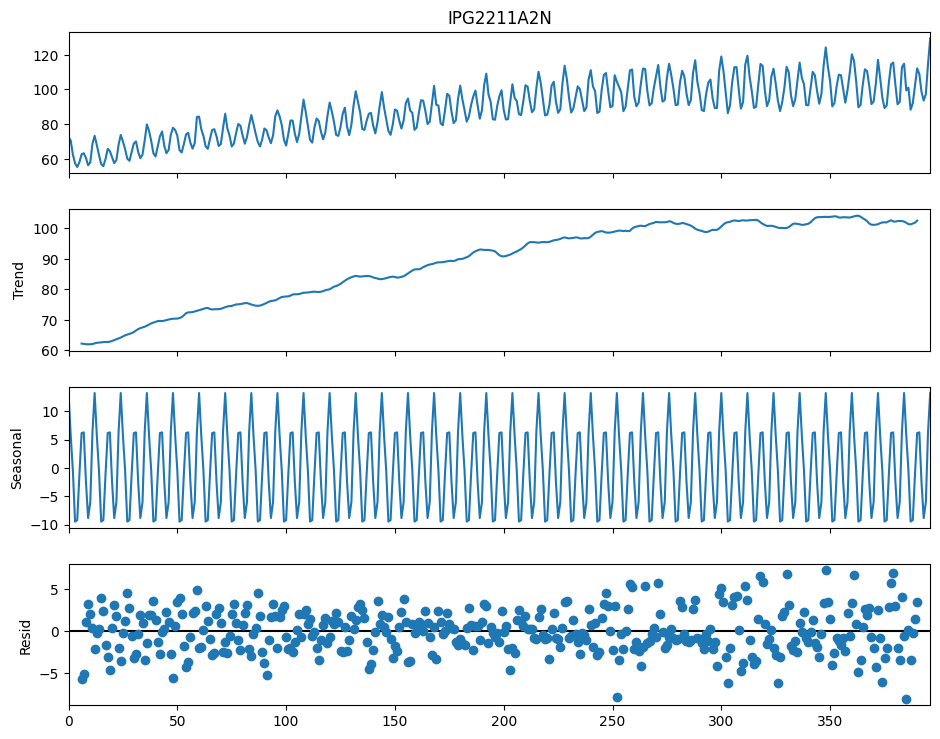

In [55]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# разложение (model='additive' или 'multiplicative')
result = seasonal_decompose(ts['IPG2211A2N'], model='additive', period=12)

# построение графиков
fig = result.plot()
fig.set_size_inches(10, 8)
plt.show()

In [56]:
ts = ts.set_index('DATE')

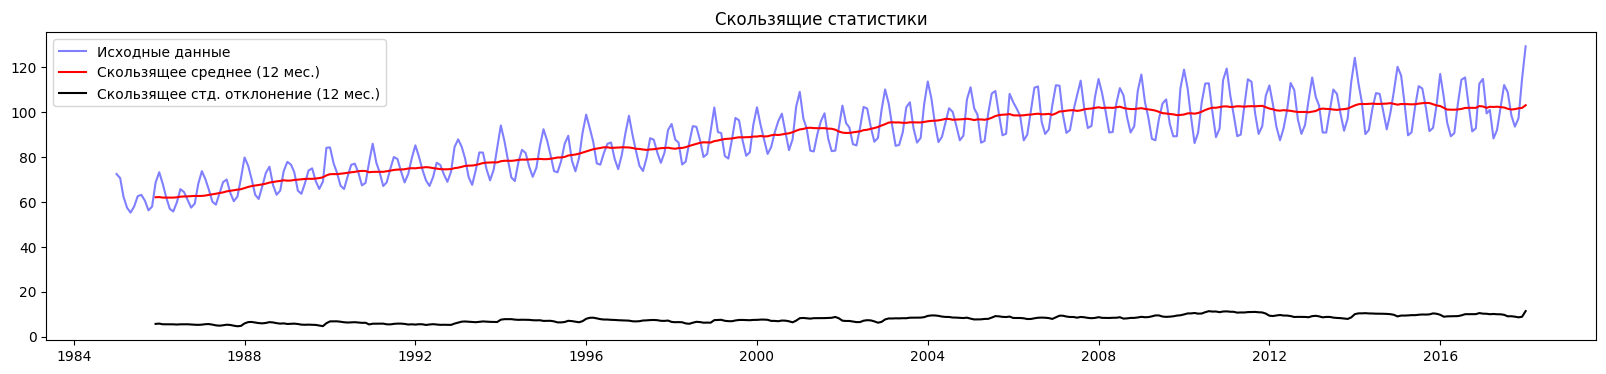

In [57]:
roll_mean = ts.IPG2211A2N.rolling(window=12).mean()
roll_std = ts.IPG2211A2N.rolling(window=12).std()

plt.figure(figsize=(20, 4))
plt.plot(ts.IPG2211A2N, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (12 мес.)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (12 мес.)')
plt.legend(loc='best')
plt.title('Скользящие статистики')
plt.show()

In [58]:
# Как показывают графики, наш ряд имеет ярко выраженный тренд, поэтому оптимально попробовать дифференцирование, чтобы сделать ряд стационарным
ts_diff = ts.diff().dropna()

In [59]:
# Повторно проверяем ряд на стационарность
result_1 = adfuller(ts_diff['IPG2211A2N'])

# результат — это tuple:
print('ADF Statistic:', result_1[0])       # статистика теста
print('p-value:', result_1[1])             # p-значение
print('Used lags:', result_1[2])           # число лагов
print('Number of observations:', result_1[3])  # число наблюдений
print('Critical Values:', result_1[4])     # критические значения

ADF Statistic: -7.104890882267311
p-value: 4.0777865655394095e-10
Used lags: 14
Number of observations: 381
Critical Values: {'1%': np.float64(-3.4476305904172904), '5%': np.float64(-2.869155980820355), '10%': np.float64(-2.570827146203181)}


Теперь ряд стационарен.

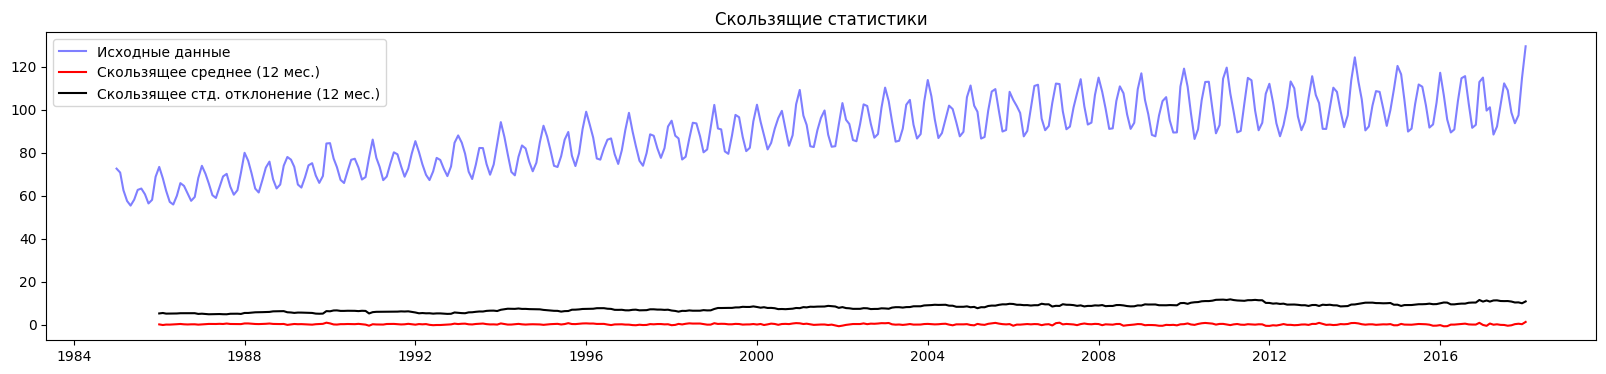

In [60]:
roll_mean = ts_diff.IPG2211A2N.rolling(window=12).mean()
roll_std = ts_diff.IPG2211A2N.rolling(window=12).std()

plt.figure(figsize=(20, 4))
plt.plot(ts.IPG2211A2N, color='blue', label='Исходные данные', alpha=0.5)
plt.plot(roll_mean, color='red', label='Скользящее среднее (12 мес.)')
plt.plot(roll_std, color='black', label='Скользящее стд. отклонение (12 мес.)')
plt.legend(loc='best')
plt.title('Скользящие статистики')
plt.show()

In [61]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

values = ts_diff['IPG2211A2N'].values.reshape(-1, 1)

# нормализация
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# функция для создания окон
def create_sequences(data, window=12):
    X, y = [], []
    for i in range(len(data) - window):
        X.append(data[i:i+window])
        y.append(data[i+window])
    return np.array(X), np.array(y)

X, y = create_sequences(scaled, window=12)

train_size = int(len(X) * 0.8)  # 80% на обучение, 20% на тест

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


# форма для Keras: (samples, timesteps, features)
print(X.shape, y.shape)


(384, 12, 1) (384, 1)


In [18]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense

model = Sequential([
    GRU(64, input_shape=(X.shape[1], X.shape[2])),
    Dense(1)  # предсказываем одно значение
])

model.compile(optimizer='adam', loss='mse')
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 64)             │        12,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,929 (50.50 KB)

 Trainable params: 12,929 (50.50 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

Epoch 1/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 0.1195 - val_loss: 0.0767
Epoch 2/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0449 - val_loss: 0.0858
Epoch 3/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0430 - val_loss: 0.0735
Epoch 4/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0386 - val_loss: 0.0735
Epoch 5/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0362 - val_loss: 0.0698
Epoch 6/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0342 - val_loss: 0.0685
Epoch 7/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0350 - val_loss: 0.0656
Epoch 8/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0346 - val_loss: 0.0636
Epoch 9/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0339 - val_loss: 0.0611
Epoch 10/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0305 - val_loss: 0.0589
Epoch 11/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0300 - val_loss: 0.0562
Epoch 12/50
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0305 - val_loss: 0.0534
E

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


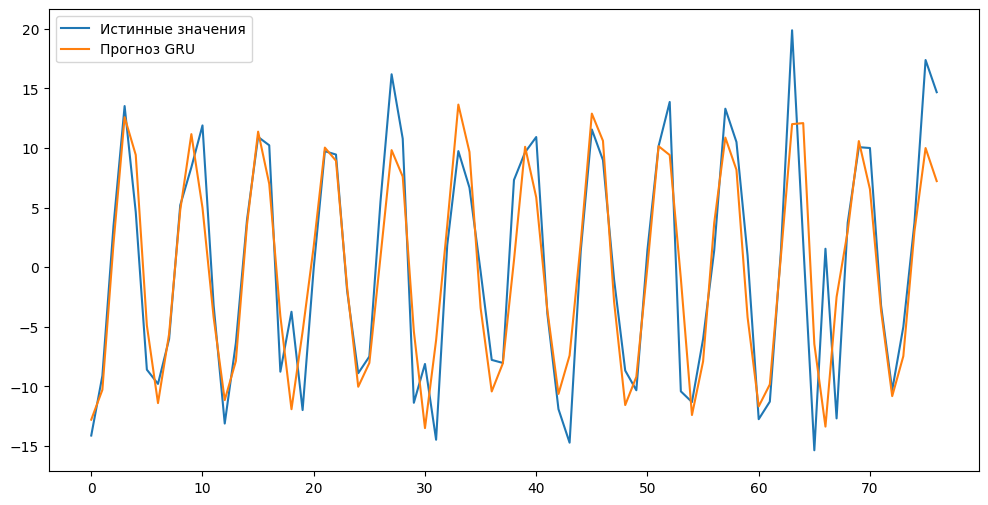

In [20]:
y_pred = model.predict(X_test)

# обратное преобразование из масштаба MinMaxScaler
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Истинные значения')
plt.plot(y_pred_inv, label='Прогноз GRU')
plt.legend()
plt.show()

In [62]:
from tensorflow.keras import Input
from tensorflow.keras.layers import LSTM, Dropout

In [63]:
# Проверяем модель LSTM
model_lstm = Sequential()

model_lstm.add(Input(shape=(12, 1)))
model_lstm.add(LSTM(units=50))
model_lstm.add(Dropout(0.2))
model_lstm.add(Dense(units=1))

model_lstm.compile(optimizer='adam', loss='mse')

In [64]:
from tensorflow.keras.callbacks import EarlyStopping

In [65]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [67]:
model_lstm.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop]
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.2111 - val_loss: 0.1231
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0708 - val_loss: 0.0807
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0471 - val_loss: 0.0778
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0407 - val_loss: 0.0772
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0422 - val_loss: 0.0764
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0407 - val_loss: 0.0756
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0373 - val_loss: 0.0753
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0360 - val_loss: 0.0751
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0373 - val_loss: 0.0745
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0375 - val_loss: 0.0740
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0350 - val_loss: 0.0736
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0363 - val_loss: 0.0732
Epoch 

In [ ]:
# обратное преобразование из масштаба MinMaxScaler
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


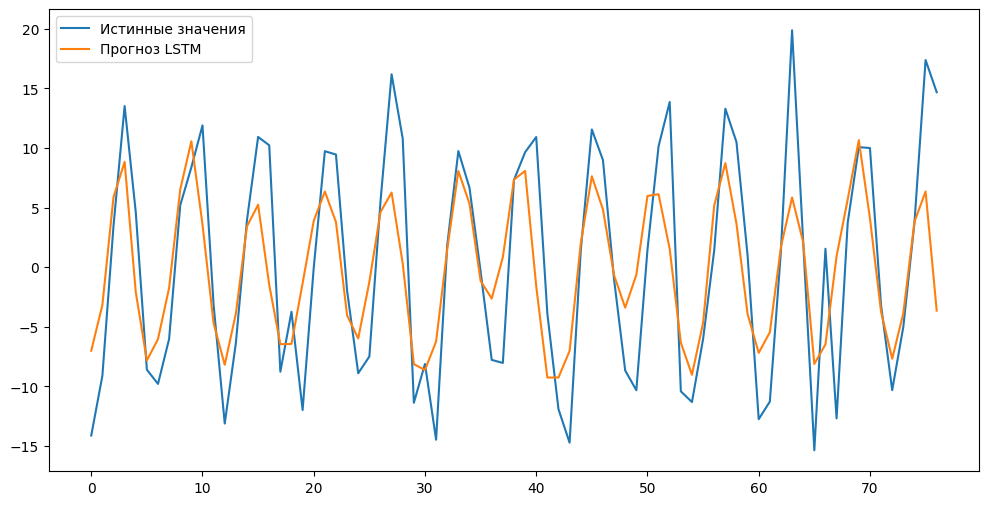

In [69]:
y_pred = model_lstm.predict(X_test)

import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot(y_test_inv, label='Истинные значения')
plt.plot(y_pred_inv, label='Прогноз LSTM')
plt.legend()
plt.show()

In [70]:
# Разложение по Фурье
from numpy.fft import fft, ifft

In [71]:
# берём исходный ряд (без дифференцирования)
signal = ts['IPG2211A2N'].values
n = len(signal)

In [72]:
# прямое преобразование Фурье
fft_values = fft(signal)

In [73]:
# оставим только первые k гармоник (низкие частоты)
k = 50
fft_filtered = np.zeros_like(fft_values)
fft_filtered[:k] = fft_values[:k]
fft_filtered[-k:] = fft_values[-k:]

In [74]:
# обратное преобразование
signal_reconstructed = np.real(ifft(fft_filtered))

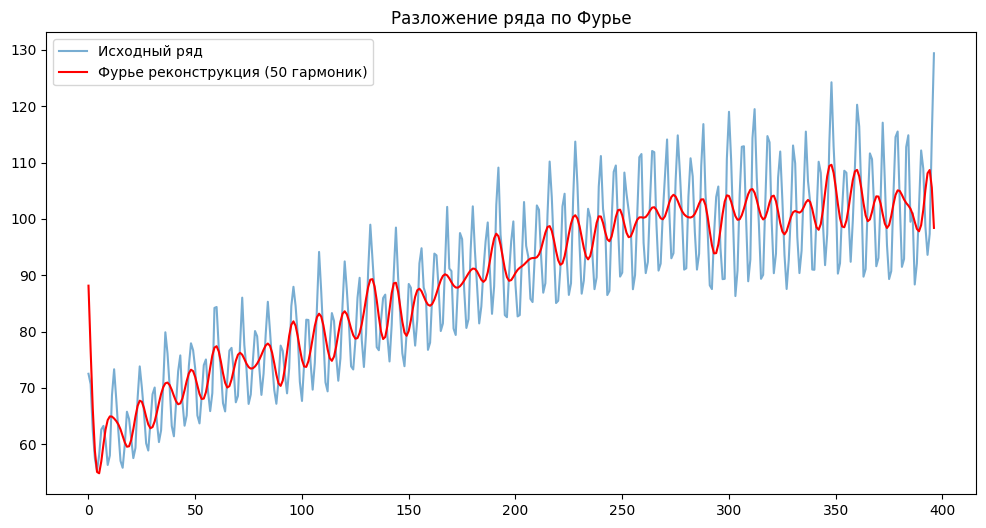

In [75]:
plt.figure(figsize=(12,6))
plt.plot(signal, label='Исходный ряд', alpha=0.6)
plt.plot(signal_reconstructed, label=f'Фурье реконструкция ({k} гармоник)', color='red')
plt.legend()
plt.title('Разложение ряда по Фурье')
plt.show()

In [76]:
# Подготовка данных для модели на основе Фурье
# нормализуем реконструированный ряд
values_fft = signal_reconstructed.reshape(-1, 1)
scaled_fft = scaler.fit_transform(values_fft)

In [77]:
X_fft, y_fft = create_sequences(scaled_fft, window=12)

train_size_fft = int(len(X_fft) * 0.8)
X_train_fft, X_test_fft = X_fft[:train_size_fft], X_fft[train_size_fft:]
y_train_fft, y_test_fft = y_fft[:train_size_fft], y_fft[train_size_fft:]

In [78]:
# --- Модель на основе LSTM для Фурье-ряда ---
model_fft = Sequential([
    LSTM(64, input_shape=(X_train_fft.shape[1], X_train_fft.shape[2])),
    Dense(1)
])

model_fft.compile(optimizer='adam', loss='mse')
history_fft = model_fft.fit(
    X_train_fft, y_train_fft,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    verbose=1
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 0.2346 - val_loss: 0.0376
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0133 - val_loss: 0.0295
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0115 - val_loss: 0.0129
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0075 - val_loss: 0.0100
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0049 - val_loss: 0.0040
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 0.0038
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0031 - val_loss: 0.0046
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0033 - val_loss: 0.0036
Epoch 10/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0031 - val_loss: 0.0037
Epoch 11/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0029 - val_loss: 0.0037
Epoch 12/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0028 - val_loss: 0.0036
Epoch 13/50


In [79]:
# Предсказание
y_pred_fft = model_fft.predict(X_test_fft)

1/3 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


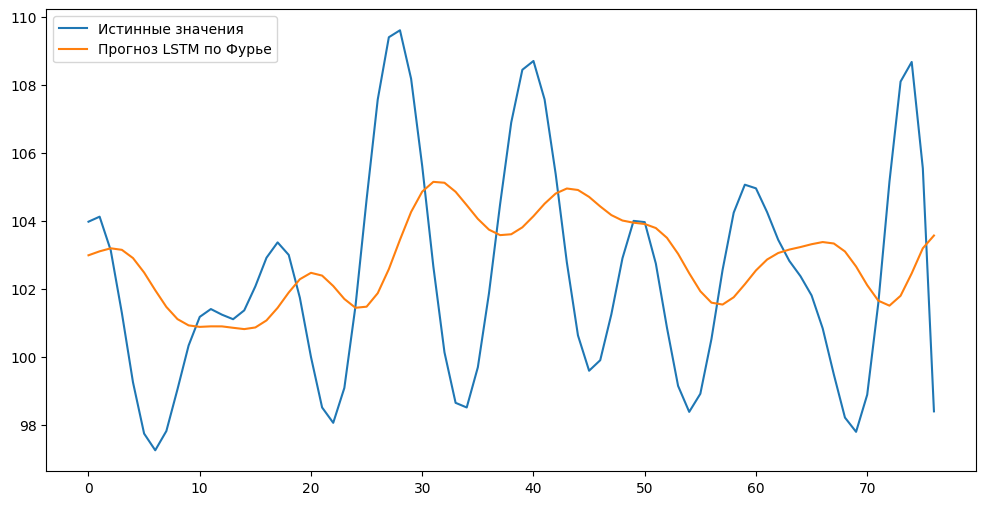

In [80]:
# обратное преобразование
y_test_fft_inv = scaler.inverse_transform(y_test_fft.reshape(-1, 1))
y_pred_fft_inv = scaler.inverse_transform(y_pred_fft)

plt.figure(figsize=(12,6))
plt.plot(y_test_fft_inv, label='Истинные значения')
plt.plot(y_pred_fft_inv, label='Прогноз LSTM по Фурье')
plt.legend()
plt.show()